In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
# =============================================================================
# 1. IMPORTING THE DATASET
# =============================================================================

binary_string_to_number_converter = lambda x: (
    1 if x == 't' else (
        0 if x == 'f' else -1 # convert x to -1 if it's NaN
    )
)

dataset = pd.read_csv(
        'airbnb_cph_listings.csv',
        # These dataset columns have mixed data types
        dtype = {
            'zipcode': str,
            'weekly_price': str,
            'monthly_price': str,
        },
        parse_dates = [
               'host_since',
               'first_review',
               'last_review',
        ],
        converters = {
            'host_is_superhost': binary_string_to_number_converter,
            'host_has_profile_pic': binary_string_to_number_converter,
            'host_identity_verified': binary_string_to_number_converter,
            'is_location_exact': binary_string_to_number_converter,
            'has_availability': binary_string_to_number_converter,
            'requires_license': binary_string_to_number_converter, 
            'instant_bookable': binary_string_to_number_converter,
            'is_business_travel_ready': binary_string_to_number_converter,
            'require_guest_profile_picture': binary_string_to_number_converter,
            'require_guest_phone_verification': binary_string_to_number_converter,
        }
)

In [3]:

# =============================================================================
# 2. PREPROCESSING
# =============================================================================

columns_to_keep = [
    'host_is_superhost',
    'host_listings_count',
    'host_verifications',
    'host_has_profile_pic',
    'host_identity_verified',
    'neighbourhood_cleansed',
    'is_location_exact',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'bed_type',
    'room_type',
    'property_type',
    'amenities',
    'guests_included',
    'extra_people',
    'minimum_nights',
    'maximum_nights',
    'has_availability',
    'availability_30', 
    'availability_60',
    'availability_90',
    'availability_365',
    'number_of_reviews',
    'number_of_reviews_ltm',
    'requires_license', 
    'instant_bookable',
    'is_business_travel_ready',
    'cancellation_policy',
    'require_guest_profile_picture',
    'require_guest_phone_verification',
    'host_since',
    'price',
]

dataset_processed = dataset.loc[:, columns_to_keep]

In [4]:

# Only very few rows don't have 'host_since' registered(9)
dataset_processed['host_since'].dropna(inplace = True)

today = datetime.today()
days_since = pd.DataFrame({
#    not using days_since_last_review and days_since_first_review
#    because thousands of rows were missing data
    'days_since_host_registration': today - dataset_processed['host_since'],
}).applymap(
    lambda x: x.days # get days as number
).apply(
    # use mean of each column for NaN values
    lambda x: x.fillna(x.mean()),
    axis = 1    
)

# join X_features with a new feature
dataset_processed = pd.DataFrame(
    pd.concat(
        [dataset_processed, days_since],
        axis = 1
    )
)
dataset_processed.drop(['host_since'], axis = 1)
    
# drop rows where feature values are NaN
# cca only 15 rows for each feature
dataset_processed = dataset_processed.dropna(subset = ['beds', 'bedrooms', 'bathrooms'])
# NaN has been converted to -1 in dataset import
dataset_processed = dataset_processed[dataset_processed['host_is_superhost'] != -1]

# convert price for extra_people into float
dataset_processed['extra_people'] = dataset_processed['extra_people'].str.replace('\$|,', '').astype(float)

dataset_processed['host_verifications_count'] = dataset_processed['host_verifications'].str.count("'\w+'")
dataset_processed.drop(['host_verifications'], axis = 1, inplace = True)

dataset_processed['amenities_count'] = dataset_processed['amenities'].str.count('[a-zA-Z0-9_ \/-]+')
dataset_processed.drop('amenities', axis=1, inplace = True)

In [5]:

# =============================================================================
# 3. ENCODING CATEGORICAL FEATURES
# =============================================================================

from sklearn.preprocessing import LabelEncoder
labelEncoderX = LabelEncoder()
dataset_processed['neighbourhood_cleansed'] = labelEncoderX.fit_transform(dataset_processed['neighbourhood_cleansed'])
dataset_processed['bed_type'] = labelEncoderX.fit_transform(dataset_processed['bed_type'])
dataset_processed['cancellation_policy'] = labelEncoderX.fit_transform(dataset_processed['cancellation_policy'])
dataset_processed['property_type'] = labelEncoderX.fit_transform(dataset_processed['property_type'])

dataset_processed['price'] = dataset_processed['price'].str.replace('\$|,', '').astype(float)

dataset_catplot = dataset_processed[['price','room_type','property_type']]

dataset_processed['room_type'] = labelEncoderX.fit_transform(dataset_processed['room_type'])


dataset_nocap = dataset_processed

dataset_processed =  dataset_processed[dataset_processed['price'] < 1600] 

# dataset_processed['availability_365'] = dataset_processed['avSailability_365'].clip(upper=365)

categorical_features = [
    'neighbourhood_cleansed',
    'bed_type',
    'cancellation_policy',
    'room_type',
    'property_type',
]

X_features = dataset_processed
X_features = X_features.drop(['price', 'host_since'], axis = 1)
y_label = dataset_processed.loc[:, ['price']]

# https://stackoverflow.com/questions/51748260/python-onehotencoder-using-many-dummy-variables-or-better-practice
# 'drop_first=True' saves you from the dummy variable trap
X_features = pd.get_dummies(X_features,columns = categorical_features, drop_first = True)


In [6]:
# =============================================================================
# 8. VISUALIZATIONS
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
y_label.describe()

,price
count,25090.000000
mean,712.358908
std,300.582197
min,0.000000
25%,498.000000
50%,678.000000
75%,897.000000
max,1595.000000


Text(0.5,1,'Histogram of listing prices')

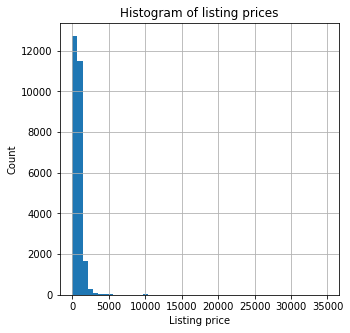

In [8]:
dataset_nocap['price'].hist(bins=50,figsize=(5,5))
plt.ylabel('Count')
plt.xlabel('Listing price')
plt.title('Histogram of listing prices')

Text(0.5,1,'Box plot of listing prices')

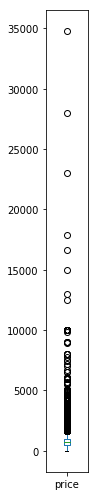

In [9]:
dataset_nocap['price'].plot(kind='box', subplots=True, layout=(1,12),figsize=(10,7), sharex=False, sharey=False)
plt.tight_layout()
plt.title('Box plot of listing prices')

Text(0.5,1,'Box plot of listing prices wihtout outliers')

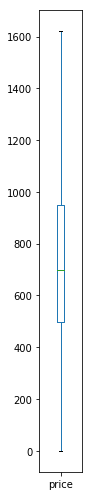

In [10]:
dataset_nocap['price'].plot(kind='box', showfliers=False, subplots=True, layout=(1,12),figsize=(10,7), sharex=False, sharey=False)
plt.tight_layout()
plt.title('Box plot of listing prices wihtout outliers')

In [11]:
corr_matrix = dataset_processed.corr()
corr_matrix["price"].sort_values(ascending=False)

price                               1.000000
accommodates                        0.513710
bedrooms                            0.480827
beds                                0.430539
guests_included                     0.256941
property_type                       0.201508
bathrooms                           0.197575
amenities_count                     0.187913
availability_365                    0.174871
availability_90                     0.171997
cancellation_policy                 0.159701
availability_60                     0.142868
availability_30                     0.142689
host_listings_count                 0.138105
extra_people                        0.113433
days_since_host_registration        0.062628
bed_type                            0.059695
maximum_nights                      0.036070
require_guest_phone_verification    0.030770
neighbourhood_cleansed              0.028033
require_guest_profile_picture       0.024247
host_verifications_count            0.020777
host_ident

Text(0.5,0.98,'Scatter plot of Listing Price against')

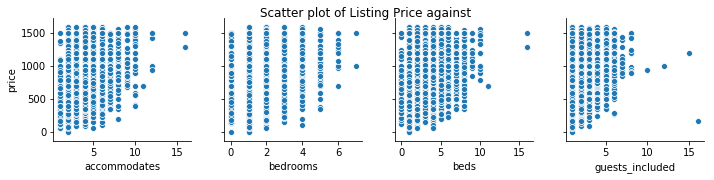

In [12]:
price_scatter = sns.pairplot(dataset_processed, x_vars=[
             "accommodates", "bedrooms", "beds","guests_included"], y_vars=["price"], diag_kind="kde")
price_scatter.fig.suptitle('Scatter plot of Listing Price against')

Text(0.5,0.98,'Scatter plot of Listing Price against')

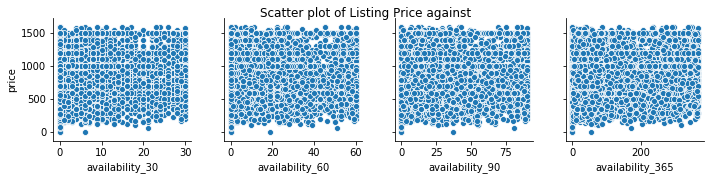

In [13]:
price_scatter = sns.pairplot(dataset_processed, x_vars=[
             "availability_30", "availability_60", "availability_90", "availability_365"], y_vars=["price"], diag_kind="kde")
price_scatter.fig.suptitle('Scatter plot of Listing Price against')

In [14]:
dataset_catplot2 =  dataset_catplot[dataset_catplot['price'] < 1600] 

<Figure size 72x432 with 0 Axes>

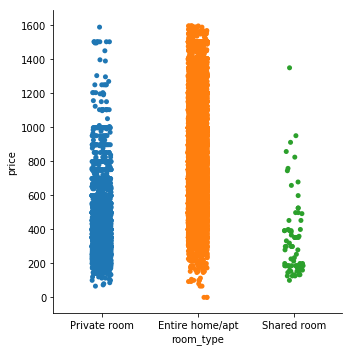

In [15]:
plt.figure(figsize=(1, 6))

sns.catplot(x='room_type',y='price', data=dataset_catplot2)

In [36]:
#sns.catplot(x='property_type',y='price', jitter=False, data=dataset_catplot2);

In [37]:
#sns.catplot(x='property_type',y='price',hue="room_type", jitter=False, data=dataset_catplot2);

In [18]:

# =============================================================================
# 4. SPLITTING THE DATASET INTO TRAINING/TESTING SETS
# =============================================================================
from sklearn.model_selection import train_test_split
XTrain, XTest, yTrain, yTest = train_test_split(X_features, y_label, random_state = 0, test_size = 0.2)


In [19]:

# =============================================================================
# 5. FEATURE SCALING
# =============================================================================

from sklearn.preprocessing import StandardScaler

# why to fit the scaler on training data only
# https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data
scaler = StandardScaler()
XTrain = scaler.fit_transform(XTrain)
XTest = scaler.transform (XTest)

In [20]:

# =============================================================================
# 6. LINEAR REGRESSION MODEL
# =============================================================================

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(XTrain, yTrain)

# Predictions
yPred = regressor.predict(XTest)

# =============================================================================
# 6.1 LINEAR REGRESSION MODEL - PREDICTIONS - BEFORE OPTIMIZATION
# =============================================================================
from sklearn.metrics import mean_squared_error, r2_score
print("\nBEFORE OPTIMIZATION")
print("Mean squared error: %.2f"
      % mean_squared_error(yTest, yPred))
# variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(yTest, yPred))


# =============================================================================
# 6.1 LINEAR REGRESSION MODEL - OPTIMIZING - BACKWARD ELIMINATION
# =============================================================================

import numpy as np
import statsmodels.formula.api as sm
from sklearn.metrics import mean_squared_error, r2_score

def backwardEliminateFeatures(features, y_label, p_threshold):    
    regressorOLS = sm.OLS(y_label, features).fit()
    # lower the pValue, higher the statistical significance
    pvalues = regressorOLS.pvalues
    
    max_pvalue_index = pvalues.argmax()
    
    if (max_pvalue_index == 'const'):
        max_pvalue_index = 0
    elif(max_pvalue_index.find('x') > -1):
        max_pvalue_index = int(max_pvalue_index[1:])

    max_pvalue = pvalues[max_pvalue_index]
    
    if(max_pvalue < p_threshold):
        return features
    else:
         features = np.delete(features, max_pvalue_index, axis=1)
         return backwardEliminateFeatures(features, y_label, p_threshold)

    
# add a column with the constant
X_features = np.append(np.ones((X_features.shape[0], 1)).astype(int), X_features, axis = 1)
X_features = backwardEliminateFeatures(X_features, y_label, 0.0001)

# =============================================================================
# 6.2 LINEAR REGRESSION MODEL - PREDICTIONS - AFTER OPTIMIZATION
# =============================================================================
XTrain, XTest, yTrain, yTest = train_test_split(X_features, y_label, random_state = 0, test_size = 0.2)

regressor = LinearRegression()
regressor.fit(XTrain, yTrain)

yPred = regressor.predict(XTest)

print("\nAFTER OPTIMIZATION")
print("Mean squared error: %.2f"
      % mean_squared_error(yTest, yPred))
# variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(yTest, yPred))



BEFORE OPTIMIZATION
Mean squared error: 45179.93
Variance score: 0.50


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.



AFTER OPTIMIZATION
Mean squared error: 43812.05
Variance score: 0.52


In [22]:
# =============================================================================
# 9. RANDOM FOREST MODEL
# =============================================================================
# create and train the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
forest.fit(XTrain,  np.ravel(yTrain))


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=3, verbose=0, warm_start=False)

In [23]:
y_train_pred = forest.predict(XTrain)
y_test_pred = forest.predict(XTest)

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(yTrain, y_train_pred),
        mean_squared_error(yTest, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(yTrain, y_train_pred),
        r2_score(yTest, y_test_pred)))

MSE train: 7143.013, test: 47126.774
R^2 train: 0.921, test: 0.482


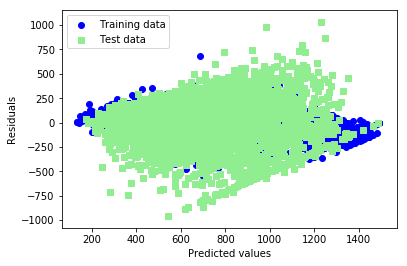

In [25]:
plt.scatter(y_train_pred,  y_train_pred - yTrain.values[:,0],
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - yTest.values[:,0],
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()

In [26]:
# =============================================================================
# 10. DNN
# =============================================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [27]:
#%%
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[XTest.shape[1]]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model


In [28]:
model = build_model()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

#  ~1000
EPOCHS = 1000

history = model.fit(
  XTrain, yTrain,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,51424.762825,171.879819,51424.762825,32723.265158,137.142328,32723.265158,995
996,51531.185146,171.171635,51531.185146,32830.309600,137.126668,32830.309600,996
997,51416.580238,171.755859,51416.580238,32714.412866,137.082934,32714.412866,997
998,51764.047326,172.645996,51764.047326,32853.790536,137.134962,32853.790536,998
999,51107.211459,170.263686,51107.211459,32763.220534,137.087000,32763.220534,999


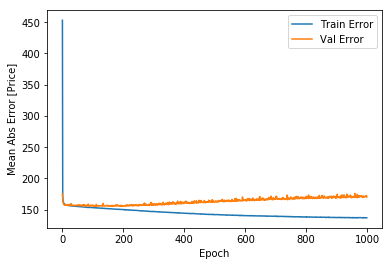

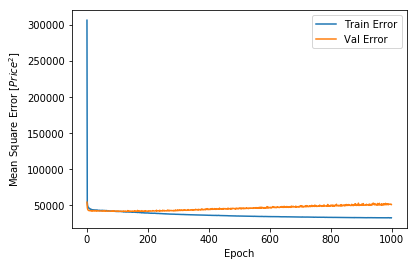

In [31]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Price]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Price^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)



............................

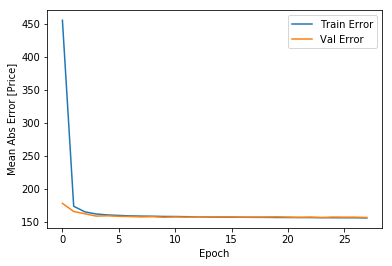

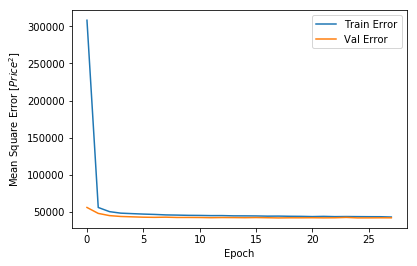

In [32]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(XTrain, yTrain, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


In [33]:
loss, mae, mse = model.evaluate(XTest, yTest, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Price".format(mae))
print("Testing set Mean Squared Error: {:5.2f} Price".format(mse))

Testing set Mean Abs Error: 159.25 Price
Testing set Mean Squared Error: 43076.70 Price


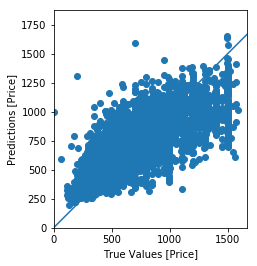

In [40]:
test_predictions = model.predict(XTest).flatten()

plt.scatter(yTest, test_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-2200, 2200], [-2200, 2200])

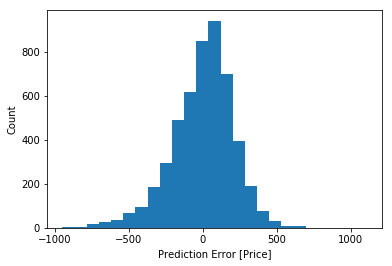

In [41]:
error = test_predictions - yTest.values[:,0]
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Price]")
_ = plt.ylabel("Count")